In [95]:
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, TimeoutError, LocalCluster
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

#code found on stack exchange
try:
    client = Client('tcp://localhost:8787', timeout='2s')
except OSError or TimeoutError:
    cluster = LocalCluster(scheduler_port=8787, n_workers=6, ip='localhost')
    client = Client(cluster)
#

client


<Client: 'tcp://127.0.0.1:8787' processes=6 threads=12, memory=16.00 GiB>

In [96]:
tweetdf = dd.read_csv(urlpath='mental_health_tweets.csv', sep='\t' )

countdf = dd.read_csv(urlpath='mental_health_tweet_count.csv', sep='\t')

print(tweetdf)

print(countdf)

Dask DataFrame Structure:
                tweet    time
npartitions=1                
               object  object
                  ...     ...
Dask Name: read-csv, 1 graph layer
Dask DataFrame Structure:
              timestamp  count
npartitions=1                 
                 object  int64
                    ...    ...
Dask Name: read-csv, 1 graph layer


In [97]:

tweetdf['time'] = dd.to_datetime(tweetdf['time'])

print(tweetdf)

countdf['timestamp'] = dd.to_datetime(countdf['timestamp'])

print(countdf)

Dask DataFrame Structure:
                tweet            time
npartitions=1                        
               object  datetime64[ns]
                  ...             ...
Dask Name: assign, 4 graph layers
Dask DataFrame Structure:
                    timestamp  count
npartitions=1                       
               datetime64[ns]  int64
                          ...    ...
Dask Name: assign, 4 graph layers


TypeError: Trying to convert dd.Scalar<ne-06fc..., dtype=bool> to a boolean value. Because Dask objects are lazily evaluated, they cannot be converted to a boolean value or used in boolean conditions like if statements. Try calling .compute() to force computation prior to converting to a boolean value or using in a conditional statement.

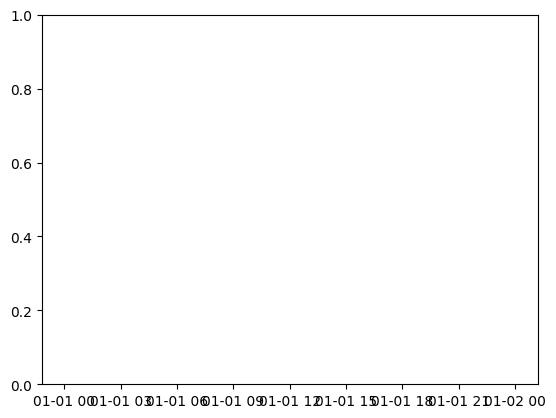

In [98]:
countdf['hour'] = countdf['timestamp'].apply    ()


#counts, bins = da.histogram(countdf, bins=len(countdf), range=[0, countdf['count'].max()])

#plt.stairs(counts, bins)